In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from pyspark.sql import SparkSession

# instantiate SparkSession object
# spark = SparkSession.builder.master('local').getOrCreate()

spark = SparkSession\
        .builder\
        .appName('ALSExample').config('spark.driver.host', 'localhost')\
        .getOrCreate()

In [3]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row
import pyspark as spark
spark = SparkSession.builder.appName('Recommendation_system').getOrCreate()
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.sql.functions import col

In [287]:
reviews = pd.read_csv('../../data/raw/ratings.csv')
links = pd.read_csv('../../data/raw/links.csv')
movies = pd.read_csv('../../data/raw/movies.csv')
tags = pd.read_csv('../../data/raw/tags.csv')

In [414]:
movies

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),"[Action, Animation, Comedy, Fantasy]"
9738,193583,No Game No Life: Zero (2017),"[Animation, Comedy, Fantasy]"
9739,193585,Flint (2017),[Drama]
9740,193587,Bungo Stray Dogs: Dead Apple (2018),"[Action, Animation]"


In [ ]:
reviews.head()

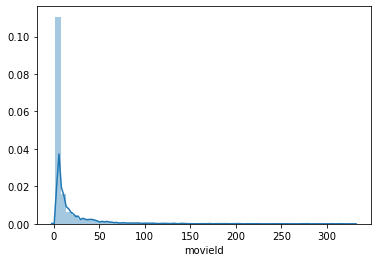

In [11]:
sns.distplot(reviews.movieId.value_counts())

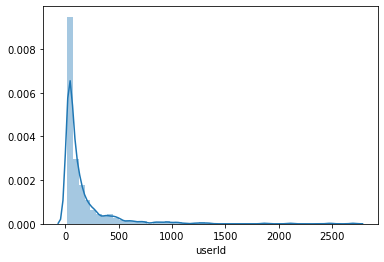

In [13]:
sns.distplot(reviews.userId.value_counts())

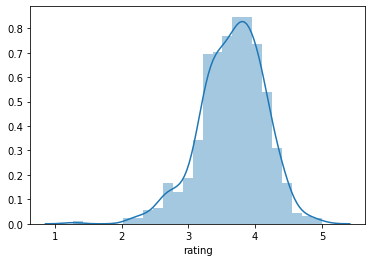

In [15]:
sns.distplot(reviews.groupby('userId')['rating'].mean())

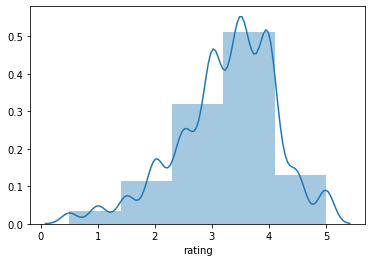

In [23]:
sns.distplot(reviews.groupby('movieId')['rating'].mean(),bins=5)

In [290]:
movies

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),"[Action, Animation, Comedy, Fantasy]"
9738,193583,No Game No Life: Zero (2017),"[Animation, Comedy, Fantasy]"
9739,193585,Flint (2017),[Drama]
9740,193587,Bungo Stray Dogs: Dead Apple (2018),"[Action, Animation]"


In [289]:
movies['genres'] = movies['genres'].apply(lambda x: x.split('|'))

# Spark ALS Model

In [291]:
movie_ratings = spark.read.csv('../../data/raw/ratings.csv', header='true', inferSchema='true')
movie_ratings = movie_ratings.drop('timestamp')

In [7]:
# split into training and testing sets
(training, test) = movie_ratings.randomSplit([0.8, 0.2])

# Build the recommendation model using ALS on the training data
# Note we set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics
als = ALS(maxIter=5,rank=4, regParam=0.01, userCol='userId', itemCol='movieId', ratingCol='rating',
          coldStartStrategy='drop')

# fit the ALS model to the training set
model = als.fit(training)

In [8]:
# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating',
                                predictionCol='prediction')
rmse = evaluator.evaluate(predictions)
print('Root-mean-square error = ' + str(rmse))

Root-mean-square error = 0.9816401507879539


In [9]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [10]:
# initialize the ALS model
als_model = ALS(userCol='userId', itemCol='movieId', 
                ratingCol='rating', coldStartStrategy='drop')

# create the parameter grid                 
params = ParamGridBuilder()\
          .addGrid(als_model.regParam, [0.01, 0.001, 0.1])\
          .addGrid(als_model.rank, [4, 10, 50]).build()


# instantiating crossvalidator estimator
cv = CrossValidator(estimator=als_model, estimatorParamMaps=params,evaluator=evaluator,parallelism=4)
best_model = cv.fit(movie_ratings)    

# We see the best model has a rank of 50, so we will use that in our future models with this dataset
best_model.bestModel.rank

4

In [54]:
def new_user_recs(user_id, new_ratings, rating_df, movie_title_df, num_recs):
    # turn the new_recommendations list into a spark DataFrame
    
    new_user_ratings = spark.createDataFrame(new_ratings,rating_df.columns)
    
    # combine the new ratings df with the rating_df
    movie_ratings_combined = rating_df.union(new_user_ratings)
    
    # split the dataframe into a train and test set
#     (training, test) = movie_ratings_combined.randomSplit([0.8, 0.2],seed=0)
    
    # create an ALS model and fit it
    als = ALS(maxIter=5, rank=50, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop")
    model = als.fit(movie_ratings_combined)
    
    # make recommendations for all users using the recommendForAllUsers method
    recommendations = model.recommendForAllUsers(num_recs)
    
    # get recommendations specifically for the new user that has been added to the DataFrame
    recs_for_user = recommendations.where(recommendations.userId == user_id).take(1)
    
    for ranking, (movie_id, rating) in enumerate(recs_for_user[0]['recommendations']):
        movie_string = name_retriever(movie_id,movie_title_df)
        print('Recommendation {}: {}  | predicted score :{}'.format(ranking+1,movie_string,rating))

In [55]:
def name_retriever(movie_id, movie_title_df):
    return movie_title_df.where(movie_title_df.movieId == movie_id).take(1)[0]['title']

In [56]:
movie_titles = spark.read.csv('../../data/raw/movies.csv', header='true', inferSchema='true')

In [57]:
movies[(movies['movieId']==3257)]

,movieId,title,genres,year
2444,3257,"Bodyguard, The (1992)","[Drama, Romance, Thriller]",1992


In [216]:
movies

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),"[Action, Animation, Comedy, Fantasy]"
9738,193583,No Game No Life: Zero (2017),"[Animation, Comedy, Fantasy]"
9739,193585,Flint (2017),[Drama]
9740,193587,Bungo Stray Dogs: Dead Apple (2018),"[Action, Animation]"


In [58]:
# try out your function with the movies listed above
user_id = 1000
user_ratings_1 = [(user_id,3257,5),
                  (user_id,2459,1),
                  (user_id,2513,2),
                  (user_id,6502,2),
                  (user_id,1091,2),
                  (user_id,441,4)]
new_user_recs(user_id,
             new_ratings=user_ratings_1,
             rating_df=movie_ratings,
             movie_title_df = movie_titles ,
             num_recs = 10)

Recommendation 1: Bodyguard, The (1992)  | predicted score :4.987308025360107
Recommendation 2: Christmas Vacation (National Lampoon's Christmas Vacation) (1989)  | predicted score :4.203624725341797
Recommendation 3: Gone with the Wind (1939)  | predicted score :4.146108627319336
Recommendation 4: Four Weddings and a Funeral (1994)  | predicted score :4.0790863037109375
Recommendation 5: Love Actually (2003)  | predicted score :4.075046539306641
Recommendation 6: Cinema Paradiso (Nuovo cinema Paradiso) (1989)  | predicted score :4.0314764976501465
Recommendation 7: Star Wars: Episode IV - A New Hope (1977)  | predicted score :4.017823696136475
Recommendation 8: First Wives Club, The (1996)  | predicted score :4.010028839111328
Recommendation 9: Dazed and Confused (1993)  | predicted score :3.998265504837036
Recommendation 10: Kingsman: The Secret Service (2015)  | predicted score :3.9860315322875977


# Making movie content filtering system

In [11]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate

In [284]:
movies = pd.read_csv('../../data/raw/movies.csv')

In [292]:
movies

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),"[Action, Animation, Comedy, Fantasy]"
9738,193583,No Game No Life: Zero (2017),"[Animation, Comedy, Fantasy]"
9739,193585,Flint (2017),[Drama]
9740,193587,Bungo Stray Dogs: Dead Apple (2018),"[Action, Animation]"


In [13]:
movies['year'] = movies['title'].apply(lambda x: x[-5:-1].strip('('))

In [15]:
movies['year'] = movies['year'].apply(lambda x: x.strip(')'))

In [16]:
movies['year'] = movies['year'].apply(lambda x: x.strip('-'))

In [17]:
movies = movies.drop(movies[movies['title'].str.contains("\(") == False].index)

In [18]:
from sklearn.preprocessing import MultiLabelBinarizer

In [19]:
mlb = MultiLabelBinarizer()

res = pd.DataFrame(mlb.fit_transform(movies['genres']),
                   columns=mlb.classes_,
                   index=movies['genres'].index)

In [20]:
genre_reviews = pd.merge(movies, res, left_index = True, right_index = True)

In [163]:
genre_reviews

,movieId,title,genres,year,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1995,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",1995,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",1995,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",1995,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),[Comedy],1995,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),"[Action, Animation, Comedy, Fantasy]",2017,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
9738,193583,No Game No Life: Zero (2017),"[Animation, Comedy, Fantasy]",2017,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
9739,193585,Flint (2017),[Drama],2017,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9740,193587,Bungo Stray Dogs: Dead Apple (2018),"[Action, Animation]",2018,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
genre_reviews = genre_reviews.drop(['genres'], axis = 1)

In [22]:
## how do we deal with these??
genre_reviews.loc[genre_reviews['(no genres listed)'] == True]

,movieId,title,year,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
8517,114335,La cravate (1957),1957,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8684,122888,Ben-hur (2016),2016,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8687,122896,Pirates of the Caribbean: Dead Men Tell No Tal...,2017,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8782,129250,Superfast! (2015),2015,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8836,132084,Let It Be Me (1995),1995,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8902,134861,Trevor Noah: African American (2013),2013,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9033,141131,Guardians (2016),2016,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9053,141866,Green Room (2015),2015,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9070,142456,The Brand New Testament (2015),2015,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9178,149330,A Cosmic Christmas (1977),1977,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [297]:
tags = pd.read_csv('../../data/raw/tags.csv')

In [298]:
tags['joined_tags'] = tags.groupby('movieId')['tag'].transform(lambda x: ' '.join(x))

In [299]:
tags

,userId,movieId,tag,timestamp,joined_tags
0,2,60756,funny,1445714994,funny Highly quotable will ferrell comedy funn...
1,2,60756,Highly quotable,1445714996,funny Highly quotable will ferrell comedy funn...
2,2,60756,will ferrell,1445714992,funny Highly quotable will ferrell comedy funn...
3,2,89774,Boxing story,1445715207,Boxing story MMA Tom Hardy
4,2,89774,MMA,1445715200,Boxing story MMA Tom Hardy
...,...,...,...,...,...
3678,606,7382,for katie,1171234019,adolescence crime for katie
3679,606,7936,austere,1173392334,austere
3680,610,3265,gun fu,1493843984,gun fu heroic bloodshed
3681,610,3265,heroic bloodshed,1493843978,gun fu heroic bloodshed


In [300]:
tags = tags[['movieId', 'joined_tags']].drop_duplicates()

In [301]:
tags

,movieId,joined_tags
0,60756,funny Highly quotable will ferrell comedy funn...
3,89774,Boxing story MMA Tom Hardy
6,106782,drugs Leonardo DiCaprio Martin Scorsese Stock ...
9,48516,way too long Leonardo DiCaprio suspense twist ...
10,431,Al Pacino gangster mafia
...,...,...
3674,1948,British
3676,5694,70mm
3677,6107,World War II
3679,7936,austere


In [28]:
tags.loc[tags.movieId == 1]

,movieId,joined_tags
629,1,pixar pixar fun


In [29]:
avg_review = pd.DataFrame(reviews.groupby('movieId')['rating'].mean())

NameError: name 'reviews' is not defined

In [ ]:
avg_review['no_of_ratings'] = reviews.groupby('movieId')['rating'].count()

In [ ]:
movies_ratings = genre_reviews.merge(avg_review, how = 'inner', on = 'movieId')

In [220]:
movies_ratings

,movieId,title,year,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,rating,no_of_ratings
0,1,Toy Story (1995),1995,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,3.920930,215
1,2,Jumanji (1995),1995,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,3.431818,110
2,3,Grumpier Old Men (1995),1995,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,3.259615,52
3,4,Waiting to Exhale (1995),1995,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,2.357143,7
4,5,Father of the Bride Part II (1995),1995,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,3.071429,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9707,193581,Black Butler: Book of the Atlantic (2017),2017,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,4.000000,1
9708,193583,No Game No Life: Zero (2017),2017,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,3.500000,1
9709,193585,Flint (2017),2017,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3.500000,1
9710,193587,Bungo Stray Dogs: Dead Apple (2018),2018,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,3.500000,1


# NLTK

In [379]:
from nltk import *
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from rake_nltk import Rake

In [ ]:
movies_w_tags['joined_tags'] = movies_w_tags['joined_tags'].apply(lambda x: x.replace(',', ''))

In [391]:
def combine_tags_genres(movies, tags):
    df = movies.merge(tags, on='movieId', how='outer')
    df['genres'] = df['genres'].apply(lambda x: ' '.join([str(elem) for elem in x]) )
    df = df[df['title'].isna()==False]
    df.loc[df['joined_tags'].isnull(),['joined_tags']] = df.loc[df['joined_tags'].isnull(),'joined_tags'].apply(lambda x:[])

    df['keywords'] = df['genres'] +' '+ df['joined_tags'].map(str)
    df = df.drop(['joined_tags'], axis=1)
    df['genres'] = df['genres'].apply(lambda x: x.split(' '))
    
    
    return df

In [392]:
movies_w_tags = combine_tags_genres(movies, tags)

### Rake

In [253]:
# movies_w_tags['joined_tags'] = movies_w_tags['joined_tags'].apply(lambda x: x.split(', '))

In [255]:
# movies_w_tags['keywords'] = movies_w_tags['genres']+movies_w_tags['joined_tags']

In [415]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [435]:
def count_vec(df):
    count_vect = CountVectorizer(stop_words='english')
    counts = count_vect.fit_transform(df.keywords)
    cos_sim = cosine_similarity(counts, counts)
    
    return cos_sim
def recommendations(title, cos_sim = cos_sim):
    
    # initializing the empty list of recommended movies
    recommended_movies = []
    
    # gettin the index of the movie that matches the title
    idx = indices[indices == title].index[0]

    # creating a Series with the similarity scores in descending order
    score_series = pd.Series(cos_sim[idx]).sort_values(ascending = False)

    # getting the indexes of the 10 most similar movies
    top_10_indexes = list(score_series.iloc[1:11].index)
    
    # populating the list with the titles of the best 10 matching movies
    for i in top_10_indexes:
        recommended_movies.append(list(movies_w_tags.index)[i])
        
    return recommended_movies

In [436]:
recommendations(0, count_vec(movies_w_tags))

[1757, 2355, 3000, 7760, 1706, 9430, 6486, 6194, 6948, 3568]

In [430]:
print(movies_w_tags.loc[movies_w_tags.index == 0])

   movieId             title  \
0        1  Toy Story (1995)   

                                              genres  \
0  [Adventure, Animation, Children, Comedy, Fantasy]   

                                            keywords  
0  Adventure Animation Children Comedy Fantasy pi...  


In [434]:
print(movies_w_tags.loc[movies_w_tags.index == 7760])

      movieId                                              title  \
7760    91355  Asterix and the Vikings (Astérix et les Viking...   

                                                 genres  \
7760  [Adventure, Animation, Children, Comedy, Fantasy]   

                                            keywords  
7760  Adventure Animation Children Comedy Fantasy []  


## TFIDF

In [427]:
vectorizer = TfidfVectorizer(stop_words = 'english')
X = vectorizer.fit_transform(movies_w_tags.keywords)
tfidf_cos = cosine_similarity(X, X)
recommendations(1, tfidf_cos)

[9692, 6254, 9565, 7426, 6389, 53, 1514, 9336, 8719, 767]

In [428]:
def tfidf_recs(title, cos_sim = tfidf_cos):
    
    # initializing the empty list of recommended movies
    recommended_movies = []
    
    # gettin the index of the movie that matches the title
    idx = indices[indices == title].index[0]

    # creating a Series with the similarity scores in descending order
    score_series = pd.Series(cos_sim[idx]).sort_values(ascending = False)

    # getting the indexes of the 10 most similar movies
    top_10_indexes = list(score_series.iloc[1:21].index)
    
    # populating the list with the titles of the best 10 matching movies
    for i in top_10_indexes:
        recommended_movies.append(list(movies_w_tags.index)[i])
        
    return title, recommended_movies

In [429]:
tfidf_recs(0)

(0,
 [1757,
  2355,
  8695,
  9430,
  8219,
  3568,
  3000,
  8927,
  2809,
  6948,
  7760,
  1706,
  6194,
  6486,
  8900,
  6944,
  5087,
  2539,
  3230,
  3336])

In [632]:
def genre_choose(rec_outputs, movies):
    match_list = []
#     count = 0
    original_movie_genres = movies.loc[movies.index == rec_outputs[0]]['genres'][(rec_outputs[0])]
    for i in rec_outputs[1]:
        movie = movies.loc[movies.index == i]['genres'].values[0]
        for genre in movie:
#             count = 0
            for genrez in original_movie_genres:
#                 count = 0
#                 print(genrez)
#                 print(genre)
                if genrez == genre:
                    match_list.append(movies[movies.index == i]['title'])
#                     print(count)
#                     count = count + 1
    return match_list
            
            

In [652]:
print(movies_w_tags.loc[movies_w_tags.index == 758])
genre_choose(tfidf_recs(758), movies_w_tags)

     movieId             title                        genres  year  \
758     3877  Supergirl (1984)  [Action, Adventure, Fantasy]  1984   

                               keywords  
758  Action Adventure Fantasy superhero  


[607    Mystery Men (1999)
 Name: title, dtype: object, 607    Mystery Men (1999)
 Name: title, dtype: object, 43    Batman Forever (1995)
 Name: title, dtype: object, 43    Batman Forever (1995)
 Name: title, dtype: object, 590    Superman III (1983)
 Name: title, dtype: object, 590    Superman III (1983)
 Name: title, dtype: object, 588    Superman (1978)
 Name: title, dtype: object, 588    Superman (1978)
 Name: title, dtype: object, 380    Batman Returns (1992)
 Name: title, dtype: object, 897    Spider-Man (2002)
 Name: title, dtype: object, 897    Spider-Man (2002)
 Name: title, dtype: object, 145    Batman (1989)
 Name: title, dtype: object, 589    Superman II (1980)
 Name: title, dtype: object, 751    X-Men (2000)
 Name: title, dtype: object, 751    X-Men (2000)
 Name: title, dtype: object, 1482    Man of Steel (2013)
 Name: title, dtype: object, 1482    Man of Steel (2013)
 Name: title, dtype: object, 1482    Man of Steel (2013)
 Name: title, dtype: object, 1034    Pirates of 

In [441]:
movies.loc[movies.index == 1281]


,movieId,title,genres,year
1281,1701,Deconstructing Harry (1997),"[Comedy, Drama]",1997


In [443]:
recommendations(0)

[544, 666, 1033, 812, 643, 160, 1444, 1281, 1274, 248]

## input userId and movieId

In [498]:
len(reviews[reviews['userId']==uid])

0

In [463]:
from pyspark.sql.functions import array_contains

In [582]:
user_id = 1
movie_id = 1
num_recs = 10

In [529]:
movie_ratings.filter(col('userId').isin(9999)).select('userId').summary

<bound method DataFrame.summary of DataFrame[userId: int]>

In [533]:
def user_exist(uid, reviews):
    if uid in reviews.userId:
        return True
    else:
        return False

In [577]:
def get_ratings(uid, reviews):
    user_ratings=[]
    temp = reviews[reviews['userId']==uid].loc[:,['movieId', 'rating']]
    for index, row in temp.iterrows():
        user_ratings.append((uid, row['movieId'], row['rating']))
    return user_ratings

In [578]:
new_ratings = get_ratings(user_id, reviews)

In [590]:
new_ratings_1 = [(user_id,3257,5),
                  (user_id,2459,1),
                  (user_id,2513,2),
                  (user_id,6502,2),
                  (user_id,1091,2),
                  (user_id,441,4)]
new_user_recs(user_id,
             new_ratings=new_ratings_1,
             rating_df=movie_ratings,
             movie_title_df = movie_titles ,
             num_recs = 10)

Recommendation 1: Great Escape, The (1963)  | predicted score :6.047077178955078
Recommendation 2: Unforgiven (1992)  | predicted score :5.745759963989258
Recommendation 3: Moulin Rouge (2001)  | predicted score :5.541596412658691
Recommendation 4: Love Actually (2003)  | predicted score :5.474916934967041
Recommendation 5: Shrek 2 (2004)  | predicted score :5.473565101623535
Recommendation 6: Star Wars: Episode V - The Empire Strikes Back (1980)  | predicted score :5.460605144500732
Recommendation 7: 300 (2007)  | predicted score :5.433978080749512
Recommendation 8: Avengers: Age of Ultron (2015)  | predicted score :5.412323474884033
Recommendation 9: Crouching Tiger, Hidden Dragon (Wo hu cang long) (2000)  | predicted score :5.40259313583374
Recommendation 10: To Kill a Mockingbird (1962)  | predicted score :5.390908241271973


In [591]:
movie_ratings

DataFrame[userId: int, movieId: int, rating: double]

In [592]:
movie_titles

DataFrame[movieId: int, title: string, genres: string]

In [595]:

if (user_exist(user_id, reviews)):
    new_user_recs(user_id, new_ratings, movie_ratings, movie_titles, 10)
tfidf_recs(movie_id)

Recommendation 1: Great Escape, The (1963)  | predicted score :6.047077178955078
Recommendation 2: Unforgiven (1992)  | predicted score :5.745759963989258
Recommendation 3: Moulin Rouge (2001)  | predicted score :5.541596412658691
Recommendation 4: Love Actually (2003)  | predicted score :5.474916934967041
Recommendation 5: Shrek 2 (2004)  | predicted score :5.473565101623535
Recommendation 6: Star Wars: Episode V - The Empire Strikes Back (1980)  | predicted score :5.460605144500732
Recommendation 7: 300 (2007)  | predicted score :5.433978080749512
Recommendation 8: Avengers: Age of Ultron (2015)  | predicted score :5.412323474884033
Recommendation 9: Crouching Tiger, Hidden Dragon (Wo hu cang long) (2000)  | predicted score :5.40259313583374
Recommendation 10: To Kill a Mockingbird (1962)  | predicted score :5.390908241271973


(1,
 [9692,
  6254,
  9565,
  7426,
  6389,
  53,
  1514,
  9336,
  8719,
  767,
  1556,
  9294,
  1617,
  1618,
  109,
  8230,
  6655,
  8800,
  1799,
  7478])